Author: Jacek Kozakowski

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import numpy as np

# Importing and cleaning data

In [2]:
# Source: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset?resource=download
import kagglehub
import os 

# Download latest version
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")

df = pd.read_csv(os.path.join(path, "loan_approval_dataset.csv"))

/opt/homebrew/Cellar/jupyterlab/4.3.6/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [4]:
df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [6]:
df.isna().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

## Modeling data

> **Note on Data Formatting**  
> Unfortunately, the dataset does not specify the currency used or whether the loan term is expressed in months or years. Additionally, the numeric values in several columns appear to be unusually large.  
>
> For the purposes of this project, we will assume the following:
> - The **loan term** is expressed in **months**
> - The applicant's **income** and **loan amount** values were originally stored as floats ending in `.00`, which may indicate formatting inconsistencies or scaling  
>   → Therefore, we will divide these values by **100** to bring them to a more interpretable scale.


In [7]:
# Deleting spaces from column names
cols = list(df.columns)
for i, col in enumerate(cols):
    cols[i] = col.strip()
df.columns = cols

# Deleting leading spaces in from object values
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Income and loan seem too high so im going to divide it by 100
df['income_annum'] = (df['income_annum'] / 100).astype(int)
df['loan_amount'] = (df['loan_amount'] / 100).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [8]:
# Changing categorical variables to numerical variables 
df['education'] = df['education'].map({'Graduate': 1, 'Not Graduate': 0})
df['self_employed'] = df['self_employed'].map({'Yes': 1, 'No': 0})
df['loan_status'] = df['loan_status'].map({'Approved': 1, 'Rejected': 0})
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,1,0,96000,299000,12,778,2400000,17600000,22700000,8000000,1
1,2,0,0,1,41000,122000,8,417,2700000,2200000,8800000,3300000,0
2,3,3,1,0,91000,297000,20,506,7100000,4500000,33300000,12800000,0
3,4,3,1,0,82000,307000,8,467,18200000,3300000,23300000,7900000,0
4,5,5,0,1,98000,242000,20,382,12400000,8200000,29400000,5000000,0


## Statistical analisys of the dataset

### Correlation

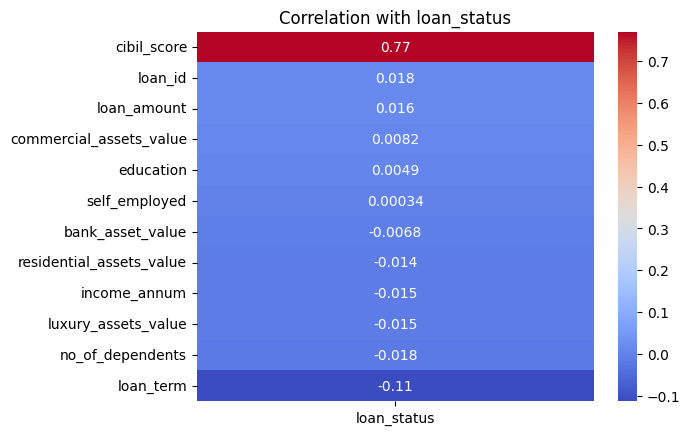

In [9]:
corr = df.corr()
loan_corr = corr['loan_status'].sort_values(ascending=False)
loan_corr = loan_corr.drop('loan_status')
sns.heatmap(loan_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation with loan_status")
plt.show()

We can see that the biggest correlation occurs for credit score

In [10]:
print(df[['cibil_score', 'loan_status']].corr())

             cibil_score  loan_status
cibil_score     1.000000     0.770518
loan_status     0.770518     1.000000


We can use box plot to see how the distribution of CIBIL scores varies between approved and rejected loans:

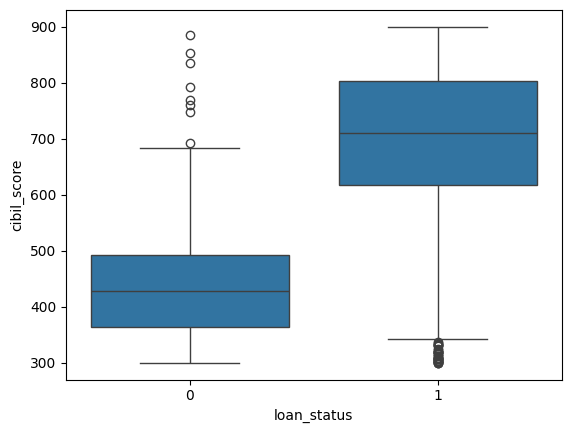

In [11]:
sns.boxplot(x = 'loan_status', y = 'cibil_score', data = df)
plt.show()

From the box plot we can see that:
* approved loans have much higher median value
* there are a lot of outliers for both approved and not approved loans

# Predicting loan approvals

## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score

### Preparing data

In [13]:
X = df[['cibil_score']]
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Training model

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Predictions

In [15]:
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred, index = X_test.index)
y_pred

1703    0
1173    1
308     0
1322    1
3271    1
       ..
912     1
443     1
1483    1
668     0
1114    0
Length: 854, dtype: int64

In [16]:
precision_score(y_test, y_pred)

0.9507575757575758

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       318
           1       0.95      0.94      0.94       536

    accuracy                           0.93       854
   macro avg       0.92      0.93      0.93       854
weighted avg       0.93      0.93      0.93       854



In [18]:
print(confusion_matrix(y_test, y_pred))

[[292  26]
 [ 34 502]]


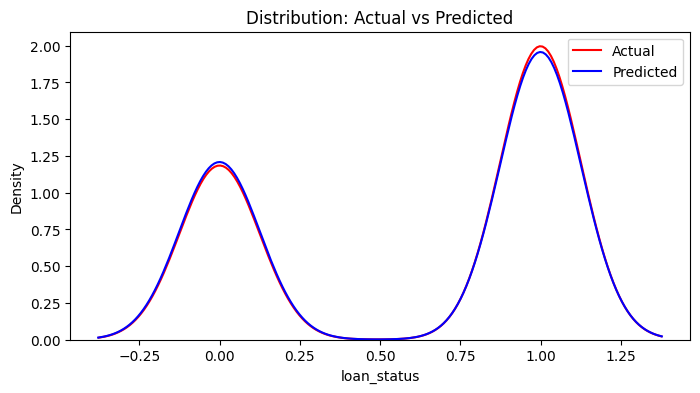

In [19]:
plt.figure(figsize=(8, 4))
sns.kdeplot(y_test, label='Actual', color='red')
sns.kdeplot(y_pred, label='Predicted', color='blue')
plt.legend()
plt.title('Distribution: Actual vs Predicted')
plt.show()

### Probabilities

In [20]:
y_proba = model.predict_proba(X_test)[:,1] # [:, 1] because we only want probabilty of the loan being approved

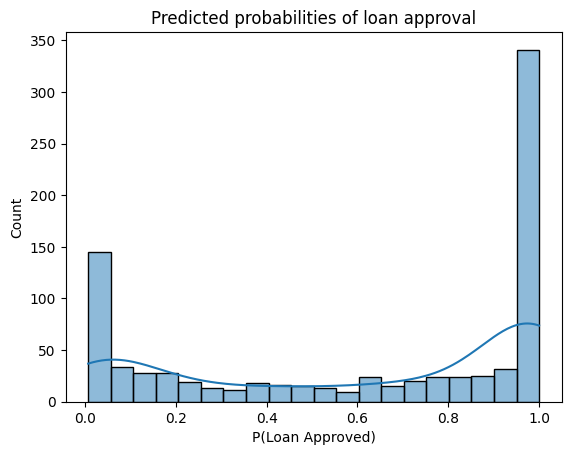

In [21]:
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Predicted probabilities of loan approval")
plt.xlabel("P(Loan Approved)")
plt.show()

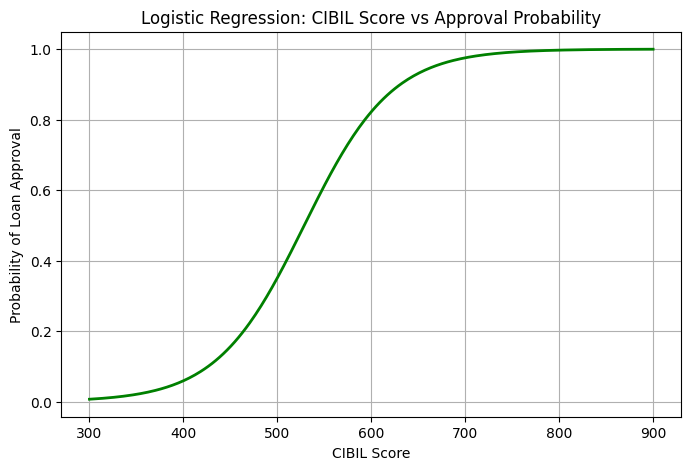

In [22]:
# Generating cibil score 
x_range = np.linspace(X['cibil_score'].min(), X['cibil_score'].max(), 300)
x_range_df = pd.DataFrame({'cibil_score': x_range})

y_proba = model.predict_proba(x_range_df)[:, 1]

# Plotting cibil score and approval probabilty
plt.figure(figsize=(8,5))
plt.plot(x_range, y_proba, color='green', linewidth=2)
plt.xlabel("CIBIL Score")
plt.ylabel("Probability of Loan Approval")
plt.title("Logistic Regression: CIBIL Score vs Approval Probability")
plt.grid(True)
plt.show()

## Random Forest
Why Random Forest?
* Handles non-linear relationships well
* Works well with both numerical and categorical data
* Feature importance, evaluates which features are the most important in making predictions
* Robust to outliers and noise

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Preparing data

In [24]:
predictors = ['cibil_score', 'loan_amount', 'income_annum', 'loan_term']
X = df[predictors]
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### Training Random Forest Model

In [25]:
rf_model = RandomForestClassifier(n_estimators = 101, min_samples_split = 30, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=30, n_estimators=101, random_state=42)

In [26]:
y_pred = rf_model.predict(X_test)
precision_score(y_test, y_pred)

0.9725776965265083

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       318
           1       0.97      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854



In [28]:
print(confusion_matrix(y_test, y_pred))

[[303  15]
 [  4 532]]


Distribution plot of predicted and true values

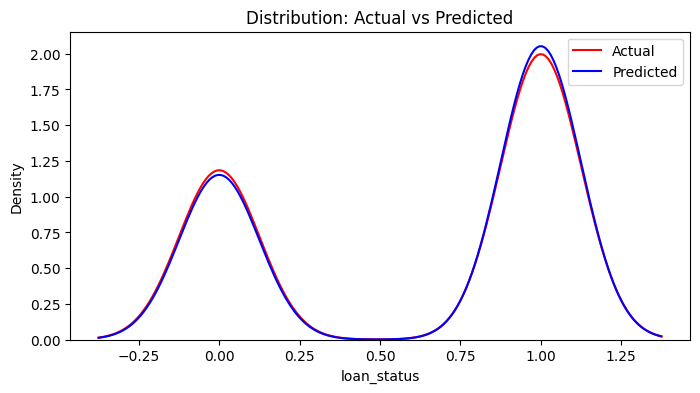

In [29]:
plt.figure(figsize=(8, 4))
sns.kdeplot(y_test, label='Actual', color='red')
sns.kdeplot(y_pred, label='Predicted', color='blue')
plt.legend()
plt.title('Distribution: Actual vs Predicted')
plt.show()

### Probabilities

#### Histogram of probabilities

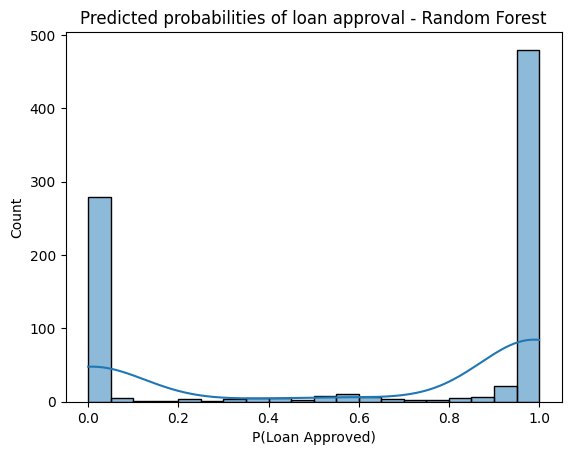

In [30]:
y_proba = rf_model.predict_proba(X_test)[:,1]
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Predicted probabilities of loan approval - Random Forest")
plt.xlabel("P(Loan Approved)")
plt.show()

#### Cibil score influence on probabilty of loan approval

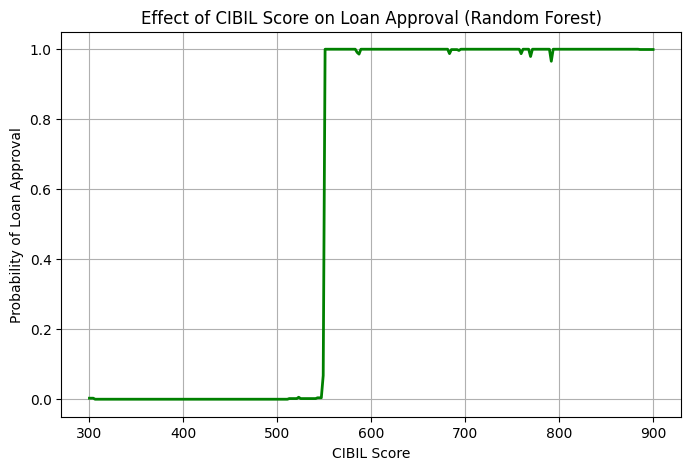

In [31]:
x_range = np.linspace(X['cibil_score'].min(), X['cibil_score'].max(), 300)
x_df = pd.DataFrame({'cibil_score': x_range})

for col in X.columns:
    if col != 'cibil_score':
        if X[col].dtype == 'object':
            x_df[col] = X[col].mode()[0]
        else:
            x_df[col] = X[col].median()

y_proba = rf_model.predict_proba(x_df)[:, 1]

plt.figure(figsize=(8,5))
plt.plot(x_range, y_proba, color='green', linewidth=2)
plt.xlabel("CIBIL Score")
plt.ylabel("Probability of Loan Approval")
plt.title("Effect of CIBIL Score on Loan Approval (Random Forest)")
plt.grid(True)
plt.show()

## Extreme Gradient Boosting
Why EGB?
* EGB outperforms traditional models like logistic regression or random forest
* EGB uses L1 and L2 regularization to reduce overfitting
* EGB is optimized for speed - it trains much faster than other gradient boosting implementation
* EGB provides feature importance metrics for model interpretability

In [32]:
from xgboost import XGBClassifier, plot_importance

### Training XGB model
We will use data that we used for Random Forest Model

In [33]:
xgb_model = XGBClassifier(eval_metric='logloss', n_estimators=102, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=102, n_jobs=None,
              num_parallel_tree=None, ...)

In [34]:
y_pred = xgb_model.predict(X_test)

In [35]:
precision_score(y_test, y_pred)

0.9797421731123389

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       318
           1       0.98      0.99      0.99       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [37]:
print(confusion_matrix(y_test, y_pred))

[[307  11]
 [  4 532]]


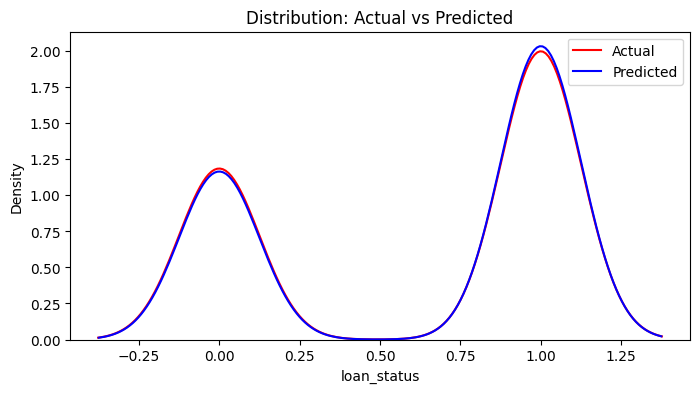

In [38]:
plt.figure(figsize=(8, 4))
sns.kdeplot(y_test, label='Actual', color='red')
sns.kdeplot(y_pred, label='Predicted', color='blue')
plt.legend()
plt.title('Distribution: Actual vs Predicted')
plt.show()

### Probabilities

In [39]:
y_proba = xgb_model.predict_proba(X_test)[:, 1]

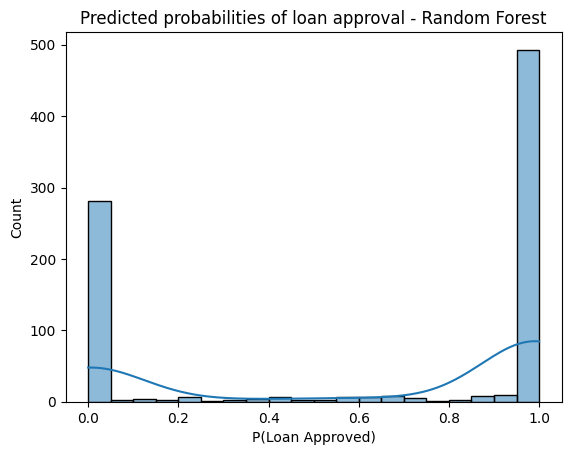

In [40]:
sns.histplot(y_proba, bins=20, kde=True)
plt.title("Predicted probabilities of loan approval - Random Forest")
plt.xlabel("P(Loan Approved)")
plt.show()

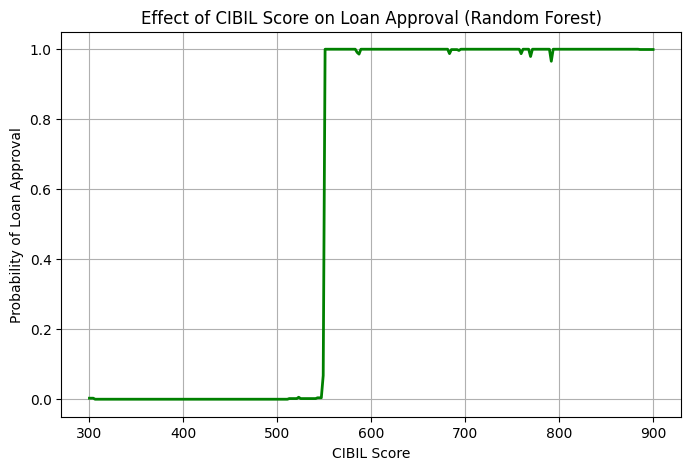

In [41]:
x_range = np.linspace(X['cibil_score'].min(), X['cibil_score'].max(), 300)
x_df = pd.DataFrame({'cibil_score': x_range})

for col in X.columns:
    if col != 'cibil_score':
        if X[col].dtype == 'object':
            x_df[col] = X[col].mode()[0]
        else:
            x_df[col] = X[col].median()

y_proba = rf_model.predict_proba(x_df)[:, 1]

# Wykres
plt.figure(figsize=(8,5))
plt.plot(x_range, y_proba, color='green', linewidth=2)
plt.xlabel("CIBIL Score")
plt.ylabel("Probability of Loan Approval")
plt.title("Effect of CIBIL Score on Loan Approval (Random Forest)")
plt.grid(True)
plt.show()

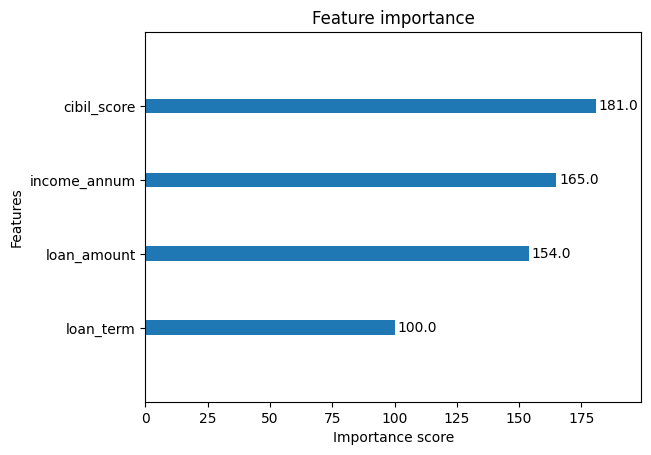

In [42]:
plot_importance(xgb_model)
plt.grid(False)
plt.show()

# Evaluating Random Forest and XGB models

## Evaluation of current Random Forest and XGB models

Let's check how the models handle predicting realistic data:

In [43]:
y_pred_rf = rf_model.predict(pd.DataFrame([[650, 100000, 75000, 24]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('Random Forest Prediction:', 'Approved' if y_pred_rf[0] else 'Rejected')
y_pred_rf = rf_model.predict(pd.DataFrame([[550, 100000, 75000, 24]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('Random Forest Prediction:', 'Approved' if y_pred_rf[0] else 'Rejected') 
y_pred_xgb = xgb_model.predict(pd.DataFrame([[650, 100000, 75000, 24]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 
y_pred_xgb = xgb_model.predict(pd.DataFrame([[550, 100000, 75000, 24]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 

Random Forest Prediction: Approved
Random Forest Prediction: Approved
XGB Prediction: Approved
XGB Prediction: Rejected


Now let's see how the models handle extreme cases. We will check what happens when we would have extremely good cibil score but low income and huge loan amount:

In [44]:
y_pred_rf = rf_model.predict(pd.DataFrame([[750, 1000000, 50000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('Random Forest Prediction:', 'Approved' if y_pred_rf[0] else 'Rejected') 
y_pred_xgb = xgb_model.predict(pd.DataFrame([[750, 1000000, 50000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 

Random Forest Prediction: Approved
XGB Prediction: Approved


We can see that models approve loans for 1,000,000 USD even though the applicant makes 50,000 USD a year and will have to pay it back in 12 months, because the applicant has a very high CIBIL score. <br>
I generated additional 1000 extreme cases. 
Let's add them to our current dataset and check how the models will perform:

In [45]:
extreme_cases = pd.read_csv('data/extreme_test_cases_1000.csv')

X_extreme = extreme_cases.drop(columns='loan_status')
y_extreme = extreme_cases['loan_status']

X_combined = pd.concat([X_train, X_extreme], ignore_index=True)
y_combined = pd.concat([y_train, y_extreme], ignore_index=True)

In [46]:
extreme_cases.head(10)

,cibil_score,loan_amount,income_annum,loan_term,loan_status
0,750,10000000,30000,36,0
1,700,5000000,1000000,60,0
2,750,1000000,100000,36,0
3,500,10000000,30000,48,0
4,650,5000000,1000000,24,0
5,500,5000000,30000,48,0
6,750,300000,100000,60,1
7,400,300000,1000000,36,0
8,600,1000000,30000,36,0
9,500,500000,100000,36,0


## Training Random Forest and XGB models with extended dataset

In [47]:
rf_w_extreme = RandomForestClassifier(n_estimators = 101, min_samples_split = 30, random_state = 42)
rf_w_extreme.fit(X_combined, y_combined)

RandomForestClassifier(min_samples_split=30, n_estimators=101, random_state=42)

In [48]:
xgb_w_extreme = XGBClassifier(eval_metric='logloss', n_estimators=102, learning_rate=0.1, max_depth=3, random_state=42)
xgb_w_extreme.fit(X_combined, y_combined)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=102, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluating new models

First let's score new models:

In [49]:
y_pred = rf_w_extreme.predict(X_test)
print('Precision score for Random Forest:', precision_score(y_test, y_pred))
print('Confusion matrix for Random Forest:\n',confusion_matrix(y_test, y_pred))
print('Classification report for Random Forest:\n',classification_report(y_test, y_pred))

Precision score for Random Forest: 0.9724770642201835
Confusion matrix for Random Forest:
 [[303  15]
 [  6 530]]
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       318
           1       0.97      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854



In [50]:
y_pred = xgb_w_extreme.predict(X_test)
print('Precision score for XGB:', precision_score(y_test, y_pred))
print('Confusion matrix for XGB:\n',confusion_matrix(y_test, y_pred))
print('Classification report for XGB:\n',classification_report(y_test, y_pred))

Precision score for XGB: 0.9704797047970479
Confusion matrix for XGB:
 [[302  16]
 [ 10 526]]
Classification report for XGB:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       318
           1       0.97      0.98      0.98       536

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854



First let's use the previous features we wanted to check:

In [51]:
y_pred_rf = rf_w_extreme.predict(pd.DataFrame([[750, 1000000, 50000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('Random Forest Prediction:', 'Approved' if y_pred_rf[0] else 'Rejected') 
y_pred_xgb = xgb_w_extreme.predict(pd.DataFrame([[750, 1000000, 50000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 

Random Forest Prediction: Rejected
XGB Prediction: Rejected


Now we can see that extreme cases can be handled. But now something else occurs:

In [52]:
y_pred_xgb = xgb_w_extreme.predict(pd.DataFrame([[600, 100000, 100000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 
y_pred_xgb = xgb_w_extreme.predict(pd.DataFrame([[585, 100000, 100000, 12]], columns=['cibil_score', 'loan_amount', 'income_annum', 'loan_term']))
print('XGB Prediction:', 'Approved' if y_pred_xgb[0] else 'Rejected') 

XGB Prediction: Rejected
XGB Prediction: Approved


>XGBoost Prediction Comparison: Small Difference in CIBIL Score
>
>In this test, we evaluated how the XGBoost model trained with additional extreme cases responds to small variations in credit score.
>
>We predicted loan approval status for two applicants with identical loan amount, income, and loan term — but with slightly different CIBIL scores:
>>
>- **Applicant 1**:  
>  `CIBIL = 600`, `loan_amount = 100,000`, `income = 100,000`, `loan_term = 12`
>   → **Prediction: Rejected**
>
>- **Applicant 2**:  
>  `CIBIL = 585`, `loan_amount = 100,000`, `income = 100,000`, `loan_term = 12`  
>  → **Prediction: Approved**
>
>This result suggests that the model is **not strictly threshold-based** on the CIBIL score. It may have learned more nuanced patterns from the training data, possibly influenced by the added synthetic examples.
>
>It also shows that **a lower credit score does not always lead to rejection**, and other features or learned interactions can still result in an approved prediction.
>
>This behavior reflects **real-world complexity**, where decisions are rarely based on a single factor alone.
